<a href="https://colab.research.google.com/github/sanuj/tf-basics/blob/master/vgg_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Download dataset and unzip.
!wget https://github.com/sanuj/tf-basics/raw/master/data/cats-dogs-small.zip
!unzip cats-dogs-small.zip

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 2s 0us/step
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 816us/step - loss: 0.6101 - acc: 0.6655 - val_loss: 0.4322 - val_acc: 0.8460
Epoch 2/30
2000/2000 [==============================] - 1s 351us/step - loss: 0.4341 - acc: 0.7970 - val_loss: 0.3539 - val_acc: 0.8580
Epoch 3/30
2000/2000 [==============================] - 1s 356us/step - loss: 0.3553 - acc: 0.8460 - val_loss: 0.3146 - val_acc: 0.8830
Epoch 4/30
2000/2000 [==============================] - 1s 352us/step - loss: 0.3064 - acc: 0.8755 - val_loss: 0.2912 

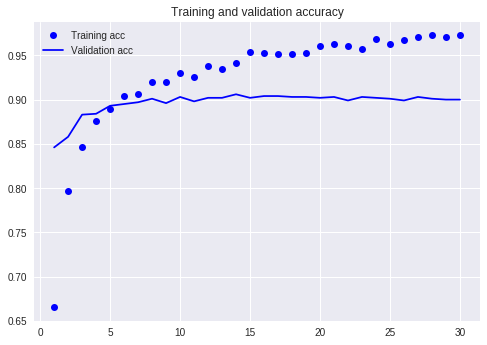

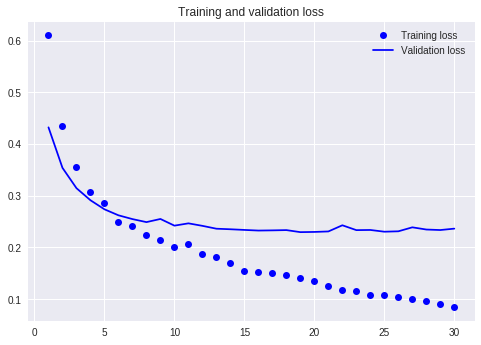

In [2]:
# Instantiating the VGG16 convolutional base
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


# Extracting features using the pretrained convolutional base
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(directory, target_size=(150, 150),
                                          batch_size=batch_size, class_mode='binary')
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  
  return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

# Reshaping extracted features
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

# Defining and training the densely connected classifier
from keras import models
from keras import layers
from keras import optimizers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

# Plotting the results
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 29s 290ms/step - loss: 0.5805 - acc: 0.7030 - val_loss: 0.4391 - val_acc: 0.8250
Epoch 2/30
100/100 [==============================] - 26s 259ms/step - loss: 0.4791 - acc: 0.7790 - val_loss: 0.3672 - val_acc: 0.8500
Epoch 3/30
100/100 [==============================] - 26s 257ms/step - loss: 0.4286 - acc: 0.8110 - val_loss: 0.3297 - val_acc: 0.8650
Epoch 4/30
100/100 [==============================] - 26s 259ms/step - loss: 0.3951 - acc: 0.8310 - val_loss: 0.3173 - val_acc: 0.8720
Epoch 5/30
100/100 [==============================] - 26s 258ms/step - loss: 0.3894 - acc: 0.8290 - val_loss: 0.2931 - val_acc: 0.8790
Epoch 6/30
100/100 [==============================] - 26s 259ms/step - loss: 0.3670 - acc: 0.8365 - val_loss: 0.3143 - val_acc: 0.8560
Epoch 7/30
100/100 [==============================] - 26s 259ms/step - loss: 0.3545 - acc: 0.8460 - val_lo

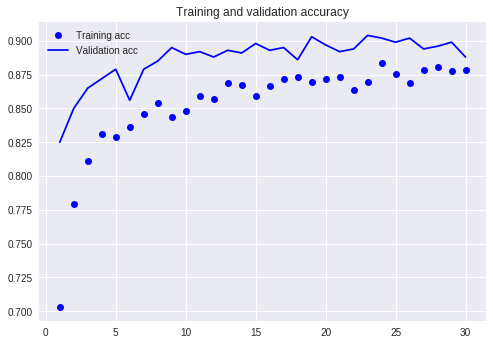

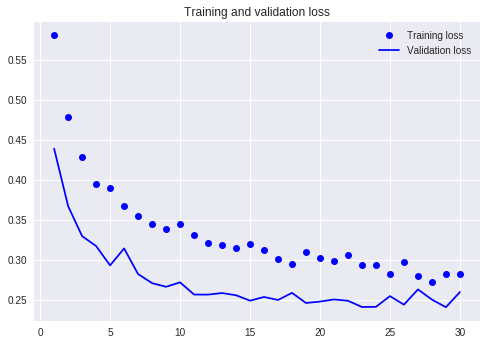

In [3]:
# Adding a densely connected classifier on top of the convolutional base
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Freezing conv base
conv_base.trainable = False

# Training the model end to end with a frozen convolutional base
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150),
                                                    batch_size=20, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150),
                                                        batch_size=20, class_mode='binary')

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30,
                              validation_data=validation_generator, validation_steps=50)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [4]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.8909999942779541
